# Model_5 : Transfert Learning based on Model_1 on top of MobileNetV2

## 1. Imports & Setup

In [1]:
# Load libraries and configuration for training.

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import kagglehub

## 2. Download Dataset

In [2]:
# Load the Animals-10 dataset from Kaggle using kagglehub.
#
# The dataset is structured as folders, one per class.

# Download dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)

# Dataset path and parameters
dataset_path = "/kaggle/input/animals10/raw-img"
IMG_SIZE = (160, 160)

Path to dataset files: /kaggle/input/animals10


## 3. Load & Preprocess Data
Convert the dataset into NumPy arrays and preprocess using MobileNetV2 pipeline.


In [3]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True
)

# Translate class names from Italian to English
class_names = dataset.class_names
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "ragno": "spider"
}
class_names = [translate.get(name, name) for name in class_names]
translated_class_names = [translate.get(name, name) for name in class_names]

# Convert tensors to NumPy
x, y = [], []
for img, label in dataset:
    x.append(img.numpy())
    y.append(label.numpy())

x = np.array(x)
y = np.array(y)

# Preprocess images
x = preprocess_input(x)

Found 26179 files belonging to 10 classes.


## 4. Split Dataset
Create 3-way split (train, validation, test).

In [4]:
# Split: Train 70%, Val 15%, Test 15%
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


## 5. Model Definition
Define a transfer learning model with a frozen MobileNetV2 base.

In [5]:
# Define model (frozen base)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint("./models/best_model_model5.keras", save_best_only=True)
earlystop_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 6. Train Model

In [6]:
# Train model with base frozen.

# Training Phase 1
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.7610 - loss: 0.7774 - val_accuracy: 0.9453 - val_loss: 0.1745
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9273 - loss: 0.2458 - val_accuracy: 0.9488 - val_loss: 0.1648
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9394 - loss: 0.1932 - val_accuracy: 0.9496 - val_loss: 0.1612
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9416 - loss: 0.1876 - val_accuracy: 0.9496 - val_loss: 0.1556
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.9457 - loss: 0.1788 - val_accuracy: 0.9524 - val_loss: 0.1542
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9438 - loss: 0.1701 - val_accuracy: 0.9524 - val_loss: 0.1478
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9526 - loss: 0.1529 - val_accuracy: 0.9539 - val_loss: 0.1503
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9492 - loss: 0.1509 - 

## 8. Plot Accuracy & Loss

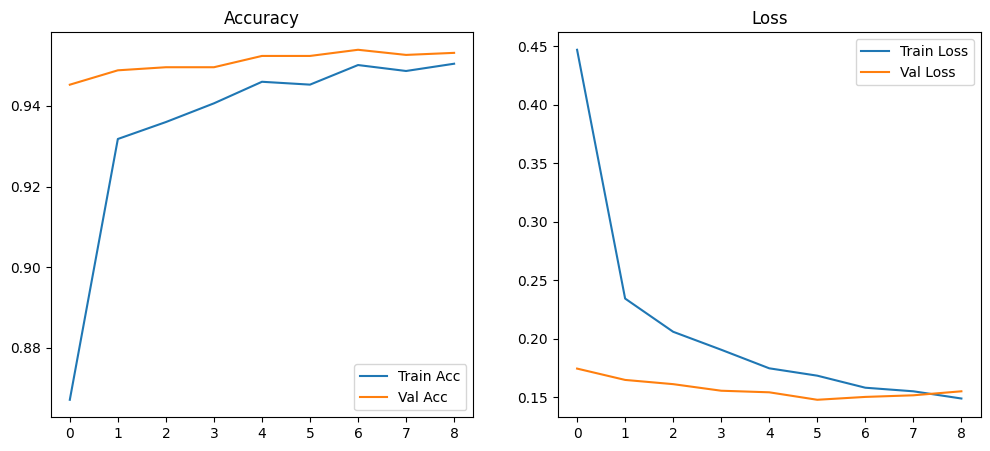

In [7]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

## 9. Evaluate on Test Set

123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step

Classification Report:
              precision    recall  f1-score   support

         dog       0.96      0.96      0.96       730
       horse       0.92      0.94      0.93       393
    elephant       0.98      0.97      0.98       217
   butterfly       0.96      0.97      0.96       317
     chicken       0.99      0.96      0.97       465
         cat       0.97      0.94      0.95       250
         cow       0.90      0.88      0.89       280
       sheep       0.92      0.95      0.93       273
      spider       0.98      0.99      0.98       723
    squirrel       0.94      0.96      0.95       279

    accuracy                           0.96      3927
   macro avg       0.95      0.95      0.95      3927
weighted avg       0.96      0.96      0.96      3927



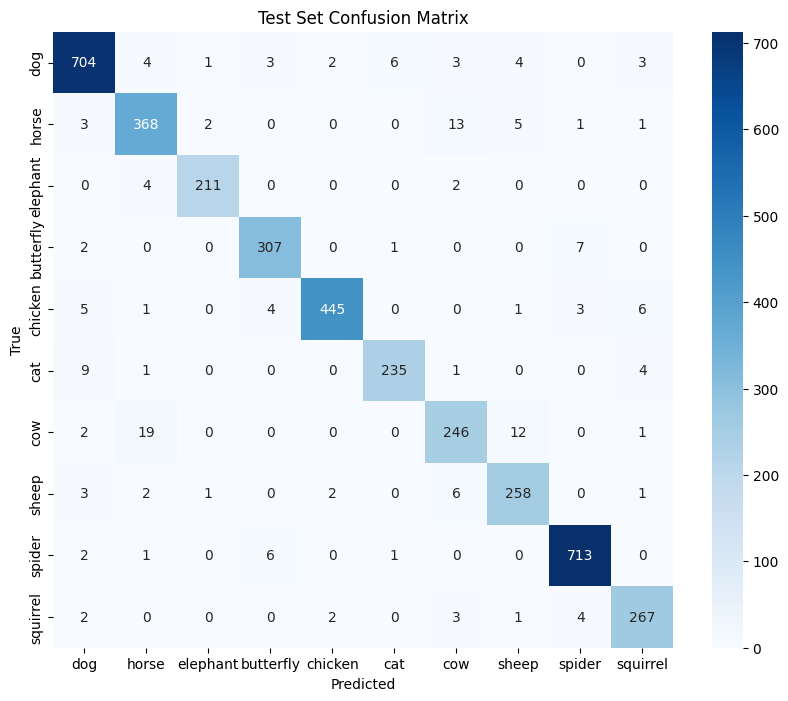

In [8]:
# Display classification report and confusion matrix.

# Evaluation on Test
y_pred = np.argmax(model.predict(x_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=translated_class_names))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=translated_class_names, yticklabels=translated_class_names)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 10. Save Predictions (optional)

In [9]:
# Save the true/predicted labels to a CSV file.

# Save Predictions
prediction_df = pd.DataFrame({
    "True Label": [translated_class_names[i] for i in y_test],
    "Predicted Label": [translated_class_names[i] for i in y_pred]
})
prediction_df.to_csv("test_predictions_model5.csv", index=False)
print("✅ Saved to test_predictions_model5.csv")

✅ Saved to test_predictions_model5.csv


## 11. Final Metrics Summary

In [10]:
# Final Metrics Summary
model.summary()  # Display the model architecture
loss, acc = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy (from model.evaluate):", acc)
print("Test Accuracy (from sklearn):", accuracy_score(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,505,888 (9.56 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 165,270 (645.59 KB)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9571 - loss: 0.1332
Test Loss: 0.13888666033744812
Test Accuracy (from model.evaluate): 0.9559460282325745
Test Accuracy (from sklearn): 0.9559460147695442
